# preprocess the linespline data
## clean linsplan file, get out the info and store all the data in dataframe

In [1]:
## import support libraries
import pandas as pd
from pandas import DataFrame 
import re
import os
import unittest

In [2]:
## get the original dimensions of the vessel

file_path = r'C:\Users\907932\Desktop\Software\Diffrac_related\Diffrac database\001_linesplan database\Original linesplan database Journee Versluis\Versluis.003'
with open(file_path) as linesplan_info:
            raw_info = linesplan_info.read().split('\n')
            info = raw_info[1]
            info_crossection = raw_info[3]
            info_pro = info.split(' ')
            vessel_name = info_pro[0][:-1]
            
            try:
                float(info_pro[2])
                vessel_type = info_pro[1]
                vesselLoA = float(info_pro[2])
                vesselBeam = float(info_pro[4])
                vesselDraft = float(info_pro[6])
                vesselDepth = float(info_pro[7][1:-1])
            except:
                vessel_type = info_pro[1] + info_pro[2]
                vesselLoA = float(info_pro[3])
                vesselBeam = float(info_pro[5])
                vesselDraft = float(info_pro[7])
                vesselDepth = float(info_pro[8][1:-1])
            num_cross_sections_pattern = re.compile(r'\d+')
            num_cross_sections_int = int(num_cross_sections_pattern.search(info_crossection).group(0))

            linesplan_info.close()



In [5]:
## get the coordinates of the scatters 
import numpy as np
import tkinter as tk
import linecache
import math
import re

'''
Hanwei Wangd RHDHV 7_2_2019
'''

class linesplan():
    def __init__(self, linsplan_path):
        self.L = None
        self.B = None
        self.T = None  # draft of the ship
        self.D = None  # depth of the ship
        self.name = None
        self.type = None
        self.coordinate = None
        self.num_cross_section = None
        self.fractions = None
        self.scaling_flag = None
        self.kxx = None
        self.kyy = None
        self.KG = None
        self.displacement = None
        self.file_path = linsplan_path

    def get_info(self):
        # get the originald ship dimensions(L, B, T, D)
        with open(self.file_path) as linesplan_info:
            raw_info = linesplan_info.read().split('\n')
            info = raw_info[1]
            info_crossection = raw_info[3]
            info_pro = info.split(' ')
            print(info_pro)
            vessel_name = info_pro[0][:-1]
            
            try:
                float(info_pro[2])
                vessel_type = info_pro[1]
                vesselLoA = float(info_pro[2])
                vesselBeam = float(info_pro[4])
                vesselDraft = float(info_pro[6])
                vesselDepth = float(info_pro[7][1:-1])
            except:
                vessel_type = info_pro[1] + info_pro[2]
                vesselLoA = float(info_pro[3])
                vesselBeam = float(info_pro[5])
                vesselDraft = float(info_pro[7])
                vesselDepth = float(info_pro[8][1:-1])
            num_cross_sections_pattern = re.compile(r'\d+')
            num_cross_sections_int = int(num_cross_sections_pattern.search(info_crossection).group(0))

            linesplan_info.close()
            
            self.L = vesselLoA
            self.B = vesselBeam
            self.T = vesselDraft
            self.D = vesselDepth
            self.name = vessel_name
            self.type = vessel_type
            self.num_cross_section = num_cross_sections_int
        linesplan_info.close()

    def get_fraction(self):

        fractions = []
        fraction_start = 4
        fraction_end = 4 + 1 + math.ceil((self.num_cross_section + 1)/6)
        for i in np.arange(fraction_start+1,fraction_end):
            line = linecache.getline(self.file_path, i)
            for fraction in line.strip('\n').split(' '):
                # print(fraction)
                if fraction != '':
                    fractions.append(float(fraction))
        self.fractions = fractions

    def get_coordinate(self):
        # First find the origin of the ship
        # X_0 is the stern of ship, y_0 is central line, z_0 is keel
        fraction_sum = [0]
        for i in range(1, len(self.fractions)+1):   # 千万注意啊
            fraction_sum.append(sum(self.fractions[0: i]))

        # print(' fraction: {}'.format(fraction_sum))
        x_cors = np.array(fraction_sum) * self.L
        
#         self.coordinate_df = DataFrame({'Crossection':[] , 'x': [], 'y':[], 'z':[]})
        self.crossection_list = []
        self.x_list = []
        self.y_list = []
        self.z_list = []
        
        with open(self.file_path, 'r') as linesplan:
             content = linesplan.read().split('\n')
             Content = []
             effective_content = content[4 + math.ceil((self.num_cross_section)/6) + 1: -3]
             for items in effective_content:
                 for item in items.split(' '):
                     if item != '':
                        Content.append(float(item))
             count = 0
             Coordinates = []

             while Content:
                 index = 1
                 num_points_per_section = int(Content[index]) + 1
                 y_cor = np.array(Content[index + 3: index + num_points_per_section*2 + 3 : 2]) * self.T
                 y_cor = np.sort(y_cor)
                 z_cor = np.array(Content[index + 2: index + num_points_per_section*2 + 2 : 2]) * self.B # !!!!!!!
                 z_cor = np.sort(z_cor)
                 # if count == 0:
                 #     y_cor = np.insert( y_cor, 0, self.T)
                 #     z_cor = np.insert(z_cor,0, 0)
                 Content = Content[index + num_points_per_section*2 + 2: ] # 不是-1, 因为列表不会包含最后一个值
                 # organize coordinate per section
                    
                 try:
                     x_cor = np.ones(len(y_cor)) * x_cors[count]
                     crossection = ['Crossection' + str(count)] * len(y_cor)
                     self.x_list += x_cor.tolist()
                     self.y_list += y_cor.tolist()
                     self.z_list += z_cor.tolist()
                     self.crossection_list += crossection
                     count += 1
                 except:
                     print('The ship model is wrong, you may lose the last cross-section!')

             linesplan.close()
             # Coordinates[0] = np.insert(Coordinates[0], 0, (0 , 0, self.T))
             # Coordinates[-1] = np.append(Coordinates[-1], (self.L, 0, self.T))
             # self.num_cross_section = self.num_cross_section
             DF_feed = {'Crossection': self.crossection_list,
                        'X': self.x_list,
                        'Y': self.y_list,
                        'Z': self.z_list}
        self.coordinate_df = DataFrame(DF_feed)

In [6]:
linesplan_processor = linesplan(linsplan_path= file_path)
linesplan_processor.get_info()
linesplan_processor.get_fraction()
linesplan_processor.get_coordinate()

['VERSLUIS.003:', 'Bulkcarrier,', '187.00', 'x', '29.00', 'x', '10.95', '(13.00)', 'meter.', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [7]:
len(linesplan_processor.fractions)

25

In [8]:
linesplan_processor.coordinate_df

,Crossection,X,Y,Z
0,Crossection0,0.00000,8.650500,0.000000
1,Crossection0,0.00000,8.938485,0.484010
2,Crossection0,0.00000,9.749880,1.438980
3,Crossection0,0.00000,10.563465,2.201100
4,Crossection0,0.00000,11.377050,2.857950
5,Crossection0,0.00000,12.187350,3.448100
6,Crossection0,0.00000,12.997650,4.004900
7,Crossection1,4.67874,0.000000,0.000000
8,Crossection1,4.67874,0.000000,0.099992
9,Crossection1,4.67874,0.000000,0.200013


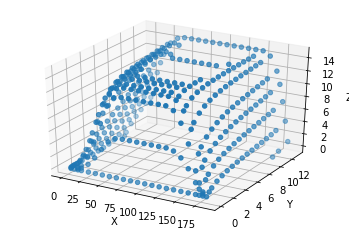

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
threedee = plt.figure().gca(projection='3d')
threedee.scatter(linesplan_processor.coordinate_df['X'], linesplan_processor.coordinate_df['Y'], linesplan_processor.coordinate_df['Z'])
threedee.set_xlabel('X')
threedee.set_ylabel('Y')
threedee.set_zlabel('Z')
plt.show()
